In [1]:
using Flux, Statistics
using Flux: crossentropy, throttle, logitcrossentropy
using Base.Iterators: repeated, partition, flatten
using DelimitedFiles
using LinearAlgebra
using RDatasets
using GLM
using BSON: @save, @load
using Random
using Base.Threads 
using Plots

┌ Warning: The NVIDIA driver on this system only supports up to CUDA 11.0.0.
│ For performance reasons, it is recommended to upgrade to a driver that supports CUDA 11.2 or higher.
└ @ CUDA /home/jupyter-nrmeskell/.julia/packages/CUDA/mVgLI/src/initialization.jl:42


In [2]:
folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
size(filter(x->occursin(string("A"), x), readdir(folder)))[1]

24000

In [3]:
function getEdepGateBarA0(number, angle)
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    angle = lpad(angle,3,"0")
    fileName = filter(x->occursin(string("A", angle), x), readdir(folder))[number]
    filePath = string(folder, fileName)
    return reshape(readdlm(filePath)[4:67, 2], (8,8))
end

getEdepGateBarA0 (generic function with 1 method)

In [4]:
function getEdepGateBarA90(number, angle)
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    angle90 = lpad(angle+90, 3, "0")
    fileName90 = filter(x->occursin(string("A", angle90), x), readdir(folder))[number]
    filePath90 = string(folder, fileName90)
    return reshape(readdlm(filePath90)[4:67,2], (8,8))
end

getEdepGateBarA90 (generic function with 1 method)

In [5]:
function getEdepGateGrid(number, angle)
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/cubes/"
    angle = lpad(angle, 3, "0")
    fileName = filter(x->occursin(string("A", angle), x), readdir(folder))[number]
    filePath = string(folder, fileName)
    return readdlm(filePath)[4:515,2]
end

getEdepGateGrid (generic function with 1 method)

dosimeter/gate_data/bars/W05__H05__A000_bars_extracted.txt

In [6]:
function getEdepOhioBarA0(number)
    folder = "/home/jupyter-nrmeskell/dosimeter/ohio_data/extracted_data/"
    fileName = filter(x->occursin(r"R...txt", x), readdir(folder))[number]
    filePath = string(folder,fileName)
    return reshape(readdlm(filePath)[4:67,2], (8,8))
end

getEdepOhioBarA0 (generic function with 1 method)

In [7]:
function getEdepOhioBarA90(number)
    folder = "/home/jupyter-nrmeskell/dosimeter/ohio_data/extracted_data/"
    fileName = filter(x->occursin(r"R.._r.txt", x), readdir(folder))[number]
    filePath = string(folder,fileName)
    return reshape(readdlm(filePath)[4:67,2], (8,8))
end

getEdepOhioBarA90 (generic function with 1 method)

In [8]:
#getEdepOhioBarA90(1)

In [9]:
function normalize(inputArray)
    min = minimum(inputArray)
    inputArray = (inputArray.-(min))
    max = maximum(inputArray)/1023
    inputArray = (inputArray./max).+1
    return inputArray
end

normalize (generic function with 1 method)

In [10]:
#normalize(getEdepOhioBarA90(1))

In [11]:
#normalize(getEdepOhioBarA0(1))

In [12]:
function makeTrainingData()
    numRuns = 15
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    trainingSize = size(filter(x->occursin("A000", x), readdir(folder)))[1]
    trainingArray = Array{Float32}(undef, 8, 8, 2, trainingSize*numRuns)
    
    for i = 1:trainingSize
        for r = 1:numRuns
            trainingArray[:, :, 1, (i-1)*numRuns + r] = getEdepGateBarA0(i,  (r-1)*15)
            trainingArray[:, :, 2, (i-1)*numRuns + r] = getEdepGateBarA90(i,  (r-1)*15)
        end
    end
    
    return trainingArray
end

makeTrainingData (generic function with 1 method)

In [13]:
function makeValidationData()
    numRuns = 18-15
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    trainingSize = size(filter(x->occursin("A000", x), readdir(folder)))[1]
    trainingArray = Array{Float32}(undef, 8, 8, 2, trainingSize*numRuns)
    for i = 1:trainingSize
        for r = 1:numRuns
            trainingArray[:, :, 1, (i-1)*numRuns + r] = getEdepGateBarA0(i, (r-1)*15 + numRuns*15)
            trainingArray[:, :, 2, (i-1)*numRuns + r] = getEdepGateBarA90(i, (r-1)*15 + numRuns*15)
        end
    end
    return trainingArray
end

makeValidationData (generic function with 1 method)

In [14]:
getEdepGateBarA0(1, (1-1)*15 + 15*15)

8×8 Matrix{Any}:
 15.4884   32.5172   40.743   1163.92  1145.86   46.834   22.3081  17.2566
 14.145    33.9486   43.7668  1114.67  1124.74   48.8679  19.0451  16.6633
  8.30427  24.0437   52.8285  1140.83  1260.51   67.7493  20.5648  12.6735
 17.951    30.5103   56.5757  1204.7   1140.1    53.5811  24.0435  14.435
 12.8398   25.341    52.8848  1281.83  1172.6    54.7688  18.8436  16.0174
 11.0505   26.6646   39.7371  1309.79  1442.98   64.9083  17.6742  12.9493
 17.6571   22.11     42.6313  1203.04  1180.21   46.0074  31.1144  10.478
  8.32462  43.5534  109.729   1149.49  1072.17  101.285   18.6303  56.6006

In [15]:
function makeTargetData()
    numRuns = 15
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/cubes/"
    trainingSize = size(filter(x->occursin("A000", x), readdir(folder)))[1]
    trainingArray = Array{Float32}(undef, 8*8*8, trainingSize*numRuns)
    for i = 1:trainingSize
        for r = 1:numRuns
            trainingArray[:, (i-1)*numRuns + r] = getEdepGateGrid(i, (r-1)*15)
        end
    end
    return trainingArray
end

makeTargetData (generic function with 1 method)

In [16]:
#makeTargetData()

In [17]:
function makeValTargetData()
    numRuns = 18-15
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/cubes/"
    trainingSize = size(filter(x->occursin("A000", x), readdir(folder)))[1]
    trainingArray = Array{Float32}(undef, 8*8*8, trainingSize*numRuns)
    for i = 1:trainingSize
        for r = 1:numRuns
            trainingArray[:, (i-1)*numRuns + r] = getEdepGateGrid(i, (r-1)*15 + 225)
        end
    end
    return trainingArray
end

makeValTargetData (generic function with 1 method)

In [18]:
#makeValTargetData()

In [19]:
function makeInputData()
    folder = "/home/jupyter-nrmeskell/dosimeter/ohio_data/extracted_data/"
    trainingSize = size(filter(x->occursin("_r.txt", x), readdir(folder)))[1]
    trainingArray = Array{Float32}(undef, 8, 8, 2, trainingSize)
    
    for i = 1:trainingSize
        trainingArray[:,:,1,i] = getEdepOhioBarA0(i)
        trainingArray[:,:,2,i] = getEdepOhioBarA90(i)
    end
    return trainingArray
end

makeInputData (generic function with 1 method)

In [20]:
#makeInputData()

In [21]:
trainingArray = makeTrainingData()

8×8×2×15000 Array{Float32, 4}:
[:, :, 1, 1] =
 14.5191   24.483    47.0369  1265.32  1165.38  60.2629  24.3078  11.4273
 17.8213   22.9725   45.0488  1197.86  1275.79  50.303   27.3961  17.1623
  9.50263  30.5865   43.1852  1265.99  1338.29  83.5827  27.3149  10.6661
  9.98321  20.824    51.0202  1430.8   1468.12  58.4172  25.2697  13.7856
 14.116    17.0707   47.7147  1399.5   1420.59  59.151   28.6669  10.0607
 10.7921   33.15     49.026   1200.67  1329.24  49.1942  30.0544  20.2622
 17.6552   23.2238   64.9896  1233.84  1258.23  62.586   29.8711  13.8479
 14.8835   71.0769  115.176   1253.78  1240.64  81.5056  48.5325  11.627

[:, :, 2, 1] =
 14.8105  26.4538  41.9192  1066.46  1169.23   48.3495  22.839   14.4685
 11.9722  25.6611  48.0718  1178.2   1205.88   44.4876  27.9193  17.1853
 17.2919  25.9948  49.5679  1088.6   1137.21   60.464   29.3549  17.7702
 17.6599  27.8983  58.3398  1157.69  1188.29   62.3831  30.0397  14.4768
 16.9457  19.7162  55.6446  1264.55  1195.86   70.1722 

In [22]:
targetArray = makeTargetData()

512×15000 Matrix{Float32}:
  1.73302  0.55928  1.48867  0.89287  …   0.85891   9.76429   2.15618
  0.33949  1.99577  0.5303   0.93859      0.45228  17.9356    0.0
  1.18177  3.06774  1.46708  1.29063     14.0921    0.0       1.65343
  1.58416  2.31329  0.98799  2.08327     12.9476    0.88577   0.30841
  2.63345  0.68919  2.64448  1.6688       2.00179   0.9801   11.0231
  1.24264  0.26561  1.72411  0.54543  …   5.93487   0.0      27.9867
  0.68612  0.32278  0.01664  0.31405      0.0       0.28935   0.0
 10.4626   0.51756  2.78773  0.5662       0.0       0.38083   1.26254
  0.38071  1.58356  1.49026  1.0653      62.251    24.8851    5.14384
  0.6765   2.01322  0.096    0.19057     44.1376   54.9953    2.98872
  0.87979  2.51411  0.12774  4.01971  …  50.5812   25.877    18.3948
  2.30144  2.17625  0.6975   2.36079     31.0851    0.85116  26.7169
  1.24405  0.96773  0.70585  1.20241      4.82942   1.08167  28.1516
  ⋮                                   ⋱                      
  0.02237  2.8

In [23]:
validationArray = makeValidationData()

8×8×2×3000 Array{Float32, 4}:
[:, :, 1, 1] =
 20.138   32.1663   52.4427  1203.7    971.864  54.4496  25.7266  18.1535
 13.8302  26.352    52.822   1250.3   1126.46   47.7267  26.8282  22.7268
 15.9903  32.0179   61.1513  1237.52  1224.74   59.1928  25.1949  15.495
 15.1472  24.4431   52.8796  1310.8   1220.92   46.1591  19.2926  21.5866
 17.5135  23.7168   42.8937  1430.15  1278.69   48.2975  25.0456  14.7557
 16.029   29.2574   41.7922  1293.78  1304.8    47.2379  26.5717  16.0603
 18.7279  21.1079   50.0174  1217.69  1259.22   59.8358  32.5749  48.6107
 13.8625  18.6153  100.462   1151.8   1244.42   89.9586  75.0965  53.2186

[:, :, 2, 1] =
 16.4262  23.9595   56.5931  1260.13  1066.21   61.9224  27.2325  10.707
 14.2442  22.4955   65.9357  1255.93  1171.24   49.5925  27.3769  12.8723
 20.9062  28.9646   59.3022  1276.64  1239.94   49.0275  22.4255  14.102
 14.7681  36.3802   63.6949  1315.74  1226.84   60.9466  23.4729   9.71859
 19.5595  24.7703   61.452   1312.85  1329.91   42.82

In [24]:
validationTargetArray = makeValTargetData()

512×3000 Matrix{Float32}:
 0.23618   0.2895    3.92071   0.0      …   0.46361   0.0      26.5556
 0.0       1.92183   1.64906   2.32204      0.99593   0.0      18.9116
 2.61043   0.26541   0.82355   0.76612      0.9608    0.51234   0.59569
 0.40921   0.58358   0.0       0.88242      1.39431   1.4718    2.62656
 2.93373   0.46956   2.60507   1.61138      0.0      14.6369    0.0
 2.29043   1.36187   0.0       0.73944  …   0.7345    8.87067   0.0
 2.07182   0.17698   0.67101   0.45498      0.46424   1.25702   0.0
 0.0       1.24304  14.8363    1.11584      0.0       1.36001   0.0
 0.55038   1.74956   2.76984   2.7473      23.2837   44.2163   63.0355
 1.02242   0.95585   1.7313    2.37489     15.4075   27.3806   91.9307
 3.71295   3.31026   1.68882   2.10312  …   0.0      21.2123   68.8116
 2.53481   3.11636   2.74005   1.93972      0.5698   18.3809    5.02516
 0.68186   0.10268   1.95464   0.97964      5.02875  20.975     0.01288
 ⋮                                      ⋱                  

In [49]:
function normalizeInput(inputArray, maxVal, minVal)
    min = minimum(inputArray)
    inputArray = (inputArray.-(min))
    max = maximum(inputArray)/maxVal
    inputArray = (inputArray./max).+1
    return inputArray
end

normalizeInput (generic function with 2 methods)

In [53]:
inputArray = normalizeInput(makeInputData(), maximum(validationArray)*2, minimum(validationArray))

8×8×2×21 Array{Float32, 4}:
[:, :, 1, 1] =
 535.725  587.19   738.595  1773.23  2934.71   757.878  591.213  534.418
 548.413  621.453  662.278  1661.83  4021.52   861.538  583.542  544.814
 509.051  556.51   780.979  2669.29  4156.85   800.462  591.183  541.715
 529.186  606.584  640.692  1723.4   6826.98   998.73   568.116  545.234
 558.757  650.495  779.652  2479.63  4877.01  1044.66   598.27   556.129
 546.231  538.272  817.525  2283.01  3445.68   960.109  607.581  544.979
 521.345  527.948  795.76   1856.1   5091.34   848.224  678.922  528.224
 495.063  531.074  601.14   1188.25  2592.89   990.638  600.241  527.509

[:, :, 2, 1] =
 266.292  303.78   619.722  1422.73   1093.44  504.271  294.899  265.267
 274.784  334.412  593.4    1221.12   1476.4   752.357  293.666  275.467
 245.125  286.365  786.959  2263.97   1480.29  657.018  298.625  269.959
 265.936  330.823  509.732  1287.68   2030.64  913.162  283.67   276.593
 288.494  370.112  790.791  1975.55   1782.75  964.308  314.553  

In [27]:
function plotResults(m)
    image = rand((1: size(validationArray)[4]))
    print(image)
    display(heatmap(reshape(Int64.(round.(m(validationArray)))[:,image], (8,8*8)), xlabel="Length/Height", ylabel="Width", title="GATE Prediction"))
    display(heatmap(reshape(validationTargetArray[:,image], (8,8*8)), xlabel="Length/Height", ylabel="Width", title="GATE Target"))
    display(heatmap(reshape(Int64.(round.(m(inputArray)))[:,1], (8,8*8)), xlabel="Length/Height", ylabel="Width", title="Ohio Data Prediction"))
end

plotResults (generic function with 1 method)

In [54]:
m = Chain(Conv((2,2), 2=>8, pad=(1,1), relu),
        Conv((2,2), 8=>16, pad=(1,1), relu),
        Dropout(0.05),

        x -> reshape(x, :, size(x,4)), 

        Dense(1600, 1200),
        Dense(1200, 8*8*8),
        x -> abs.(x))

Chain(Conv((2, 2), 2=>8, relu), Conv((2, 2), 8=>16, relu), Dropout(0.05), #47, Dense(1600, 1200), Dense(1200, 512), #48)

In [55]:
loss(x, y) = mean((m(x)-y).^2)
opt = ADAM()
dataset = (repeated((trainingArray, targetArray), 20))
evalcb = () -> @show (loss(trainingArray, targetArray)) 

CurrentR2 = r2(lm(@formula(A  ~ B), DataFrame(A=Float64.(m(trainingArray)[:,1]), B=targetArray[:,1])))
print("Training R2: ", CurrentR2, '\n')
CurrentVR2 = r2(lm(@formula(A  ~ B), DataFrame(A=Float64.(m(validationArray)[:,1]), B=validationTargetArray[:,1])))
print("Validation R2: ", CurrentVR2, '\n')

CVR2 = 0.0
i = 1

Training R2: 0.00039086690536127566
Validation R2: 0.00040115385077466037


1

loss(trainingArray, targetArray) = 911658.6f0
loss(trainingArray, targetArray) = 420662.8f0
loss(trainingArray, targetArray) = 290661.6f0
loss(trainingArray, targetArray) = 230913.12f0
loss(trainingArray, targetArray) = 183807.27f0
loss(trainingArray, targetArray) = 142300.9f0
loss(trainingArray, targetArray) = 127167.53f0
loss(trainingArray, targetArray) = 117158.26f0
loss(trainingArray, targetArray) = 93713.75f0
loss(trainingArray, targetArray) = 85398.81f0


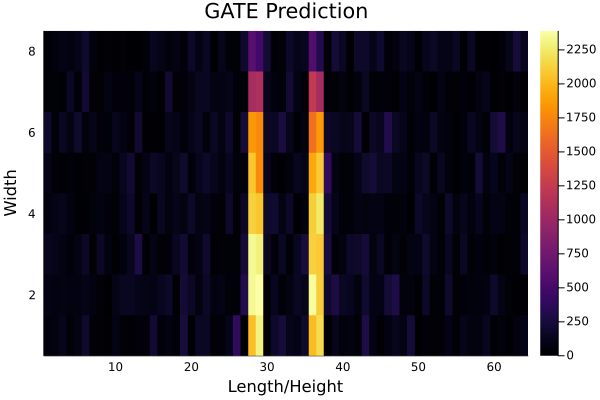

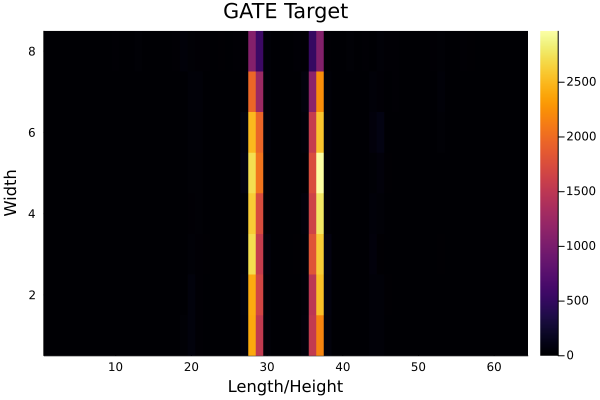

Training R2: 0.8229599199625518
Validation R2: 0.8378094780728984

	305

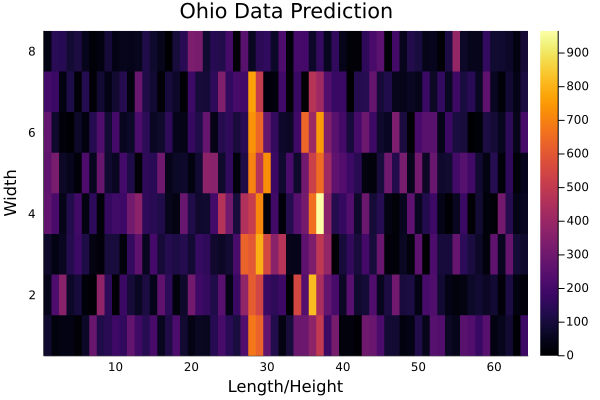

loss(trainingArray, targetArray) = 83778.984f0
loss(trainingArray, targetArray) = 81950.914f0
loss(trainingArray, targetArray) = 76942.95f0
loss(trainingArray, targetArray) = 72754.586f0
loss(trainingArray, targetArray) = 68825.23f0
loss(trainingArray, targetArray) = 65978.82f0
loss(trainingArray, targetArray) = 65260.355f0
loss(trainingArray, targetArray) = 64563.8f0
loss(trainingArray, targetArray) = 62908.758f0
Training R2: 0.8820415140267809


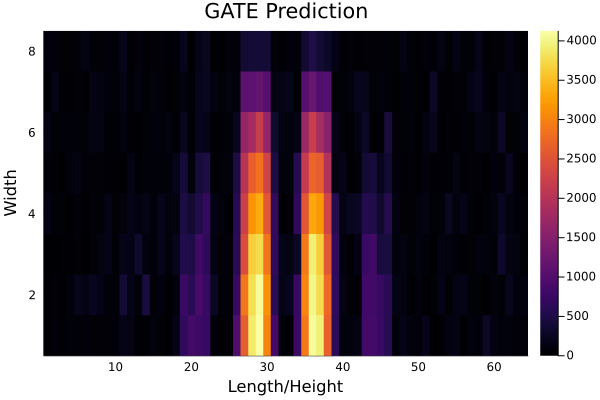

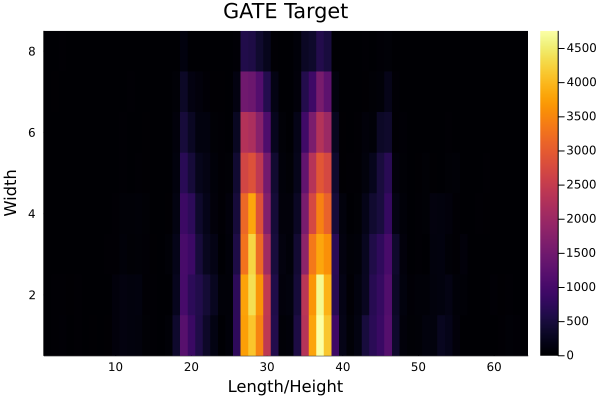

Validation R2: 0.888403244882584

	2484

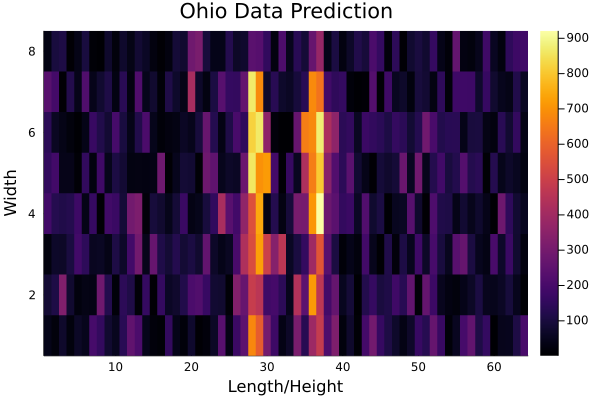

loss(trainingArray, targetArray) = 62320.598f0
loss(trainingArray, targetArray) = 61204.13f0
loss(trainingArray, targetArray) = 60455.07f0
loss(trainingArray, targetArray) = 60064.676f0
loss(trainingArray, targetArray) = 59766.6f0
loss(trainingArray, targetArray) = 59235.406f0
loss(trainingArray, targetArray) = 58861.902f0
loss(trainingArray, targetArray) = 58512.375f0
loss(trainingArray, targetArray) = 58220.734f0
loss(trainingArray, targetArray) = 57994.156f0
Training R2: 0.913908939695564


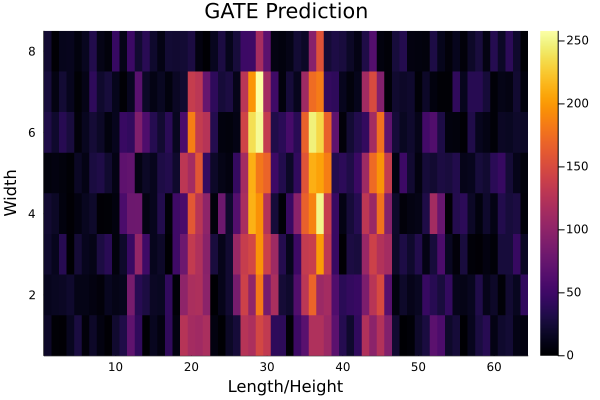

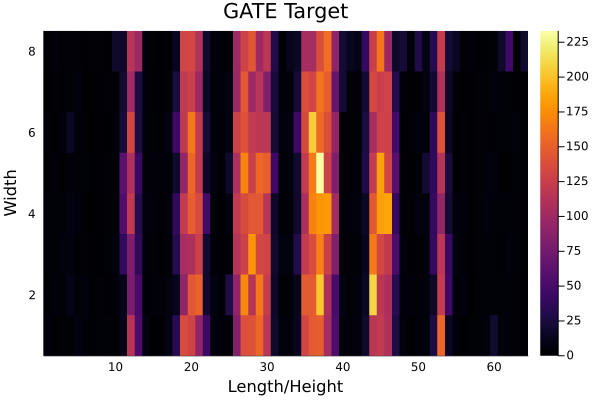

Validation R2: 0.9177562505836381

	208

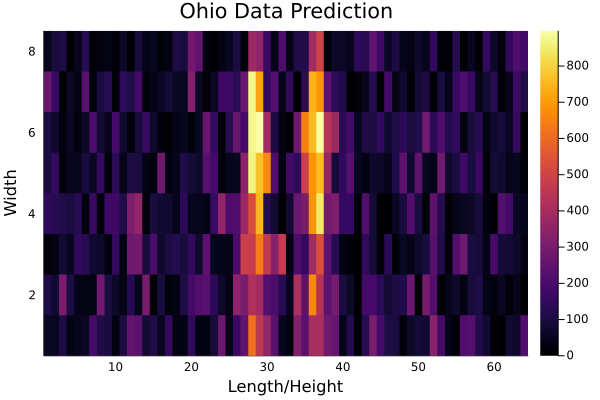

loss(trainingArray, targetArray) = 57905.37f0
loss(trainingArray, targetArray) = 57681.0f0
loss(trainingArray, targetArray) = 57526.145f0
loss(trainingArray, targetArray) = 57361.68f0
loss(trainingArray, targetArray) = 57209.42f0
loss(trainingArray, targetArray) = 57076.44f0
loss(trainingArray, targetArray) = 56955.05f0
loss(trainingArray, targetArray) = 56841.812f0
loss(trainingArray, targetArray) = 56726.793f0
loss(trainingArray, targetArray) = 56618.08f0
Training R2: 0.9296188151602417
Validation R2: 0.9327898115220946

	1460

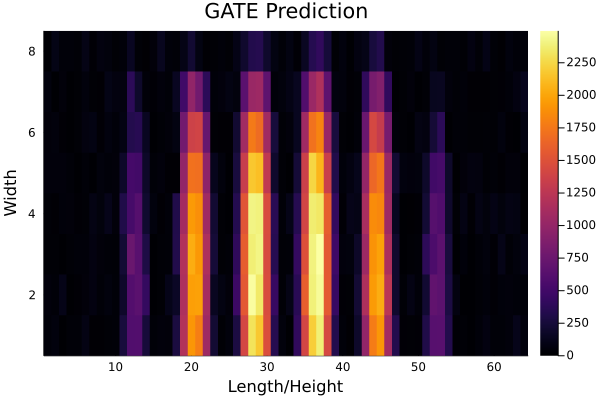

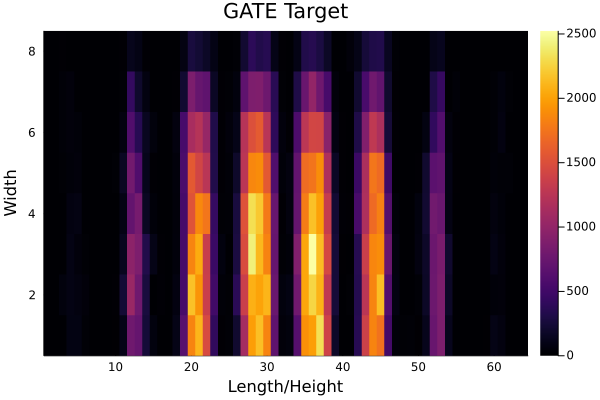

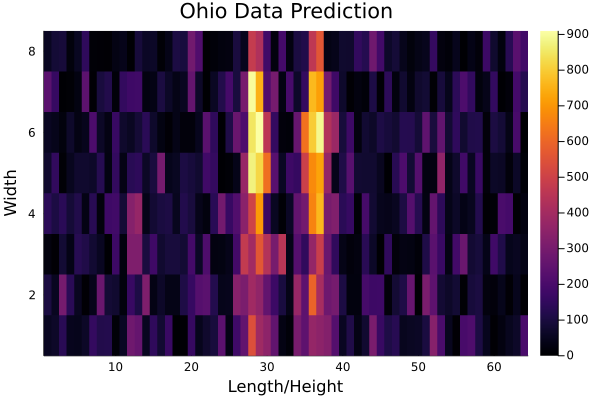

loss(trainingArray, targetArray) = 56570.816f0
loss(trainingArray, targetArray) = 56483.258f0
loss(trainingArray, targetArray) = 56400.957f0
loss(trainingArray, targetArray) = 56321.836f0
loss(trainingArray, targetArray) = 56250.64f0
loss(trainingArray, targetArray) = 56177.023f0
loss(trainingArray, targetArray) = 56109.082f0
loss(trainingArray, targetArray) = 56044.066f0
loss(trainingArray, targetArray) = 55974.996f0
loss(trainingArray, targetArray) = 55883.316f0


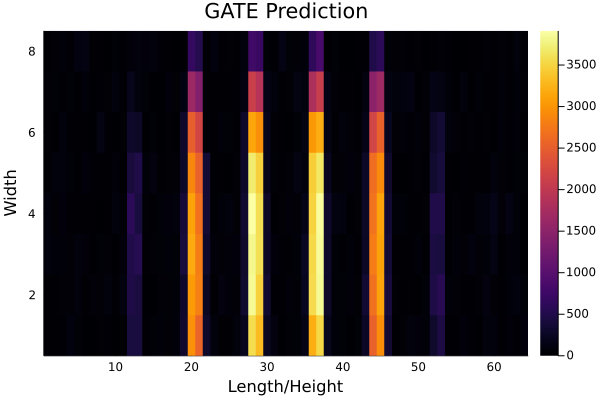

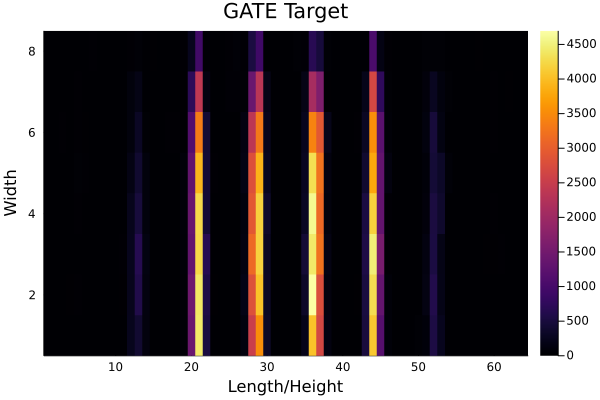

Training R2: 0.9396240579192345
Validation R2: 0.9419952597527165

	1116

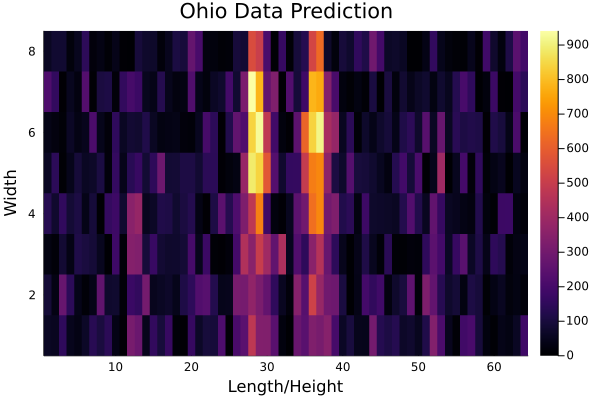

loss(trainingArray, targetArray) = 55855.965f0
loss(trainingArray, targetArray) = 55798.03f0
loss(trainingArray, targetArray) = 55744.863f0
loss(trainingArray, targetArray) = 55693.168f0
loss(trainingArray, targetArray) = 55640.32f0
loss(trainingArray, targetArray) = 55564.113f0
loss(trainingArray, targetArray) = 55513.992f0
loss(trainingArray, targetArray) = 55459.707f0
loss(trainingArray, targetArray) = 55405.176f0
loss(trainingArray, targetArray) = 55351.73f0
Training R2: 0.9472226748841246


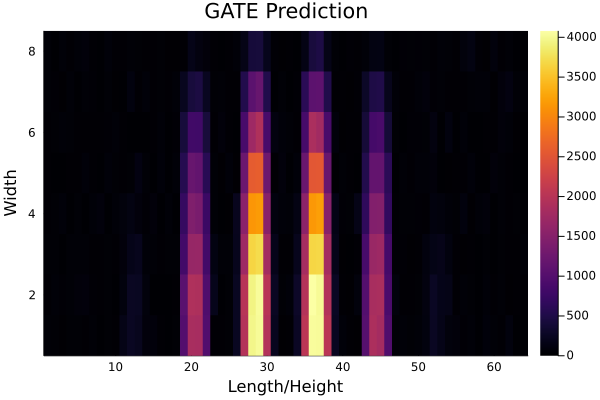

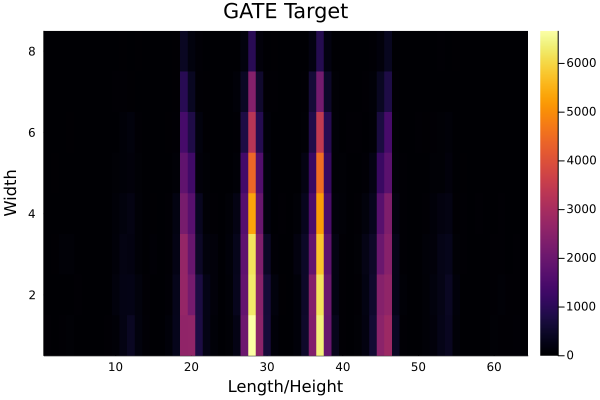

Validation R2: 0.9499861147202576

	2722

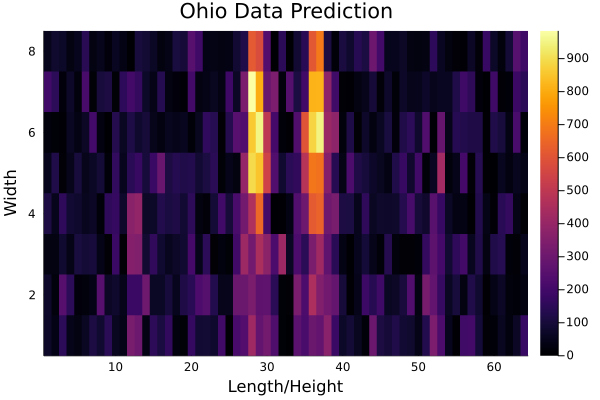

loss(trainingArray, targetArray) = 55324.723f0
loss(trainingArray, targetArray) = 55270.324f0
loss(trainingArray, targetArray) = 55192.42f0
loss(trainingArray, targetArray) = 55142.1f0
loss(trainingArray, targetArray) = 55091.39f0
loss(trainingArray, targetArray) = 55037.125f0
loss(trainingArray, targetArray) = 54981.168f0
loss(trainingArray, targetArray) = 54923.625f0
loss(trainingArray, targetArray) = 54838.527f0
Training R2: 0.9559514718129667


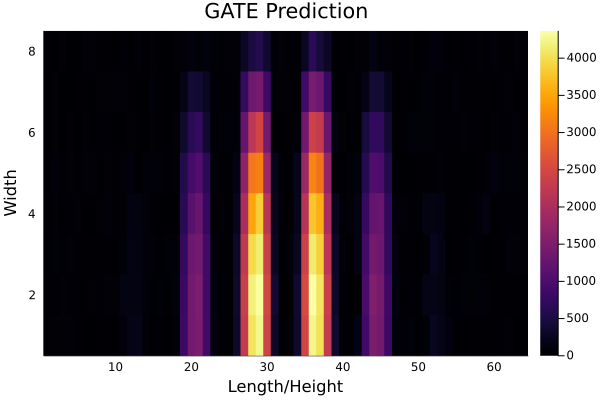

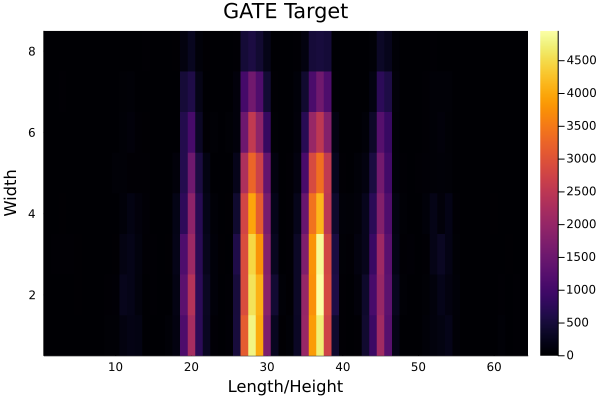

Validation R2: 0.9580773880489157

	1910

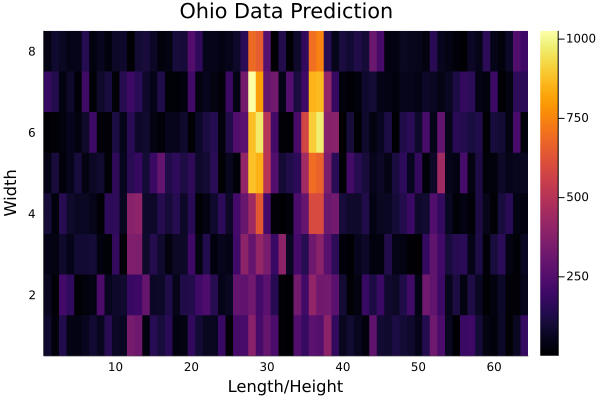

loss(trainingArray, targetArray) = 54779.594f0
loss(trainingArray, targetArray) = 54723.95f0
loss(trainingArray, targetArray) = 54649.156f0
loss(trainingArray, targetArray) = 54598.777f0
loss(trainingArray, targetArray) = 54550.938f0
loss(trainingArray, targetArray) = 54483.9f0
loss(trainingArray, targetArray) = 54437.785f0
loss(trainingArray, targetArray) = 54397.406f0
loss(trainingArray, targetArray) = 54334.72f0
Training R2: 0.9747386563475633


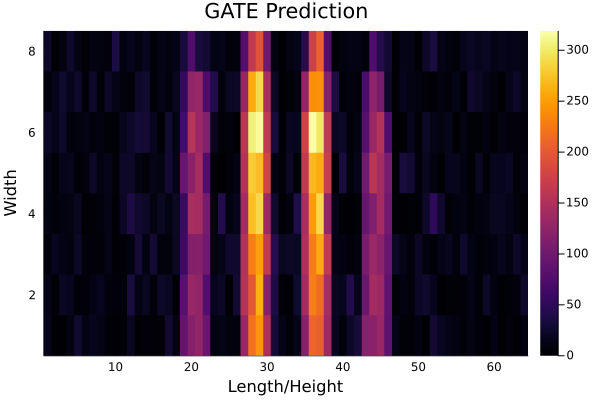

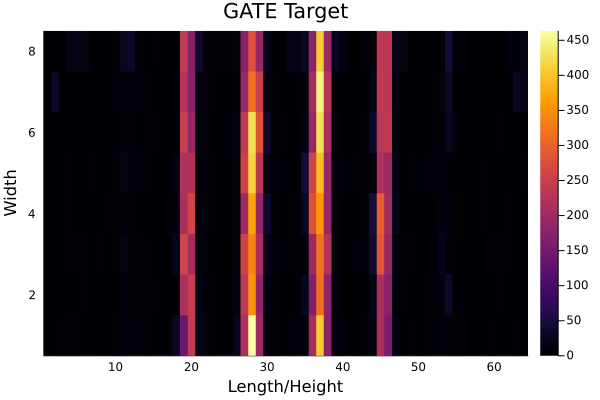

Validation R2: 0.970199789845235

	85

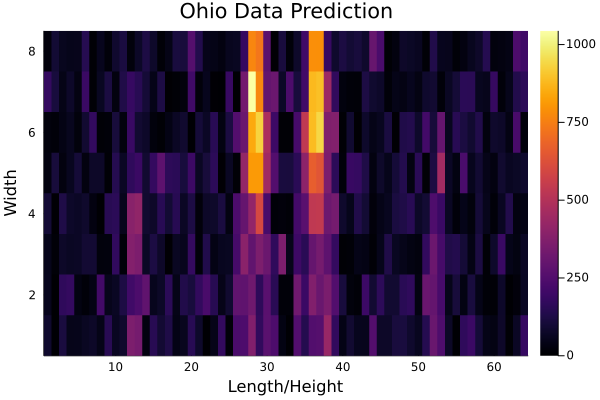

loss(trainingArray, targetArray) = 54314.77f0
loss(trainingArray, targetArray) = 54279.277f0
loss(trainingArray, targetArray) = 54224.188f0
loss(trainingArray, targetArray) = 54187.195f0
loss(trainingArray, targetArray) = 54153.883f0
loss(trainingArray, targetArray) = 54104.004f0
loss(trainingArray, targetArray) = 54071.39f0
loss(trainingArray, targetArray) = 54040.953f0
loss(trainingArray, targetArray) = 53994.39f0
Training R2: 0.9860380955316088


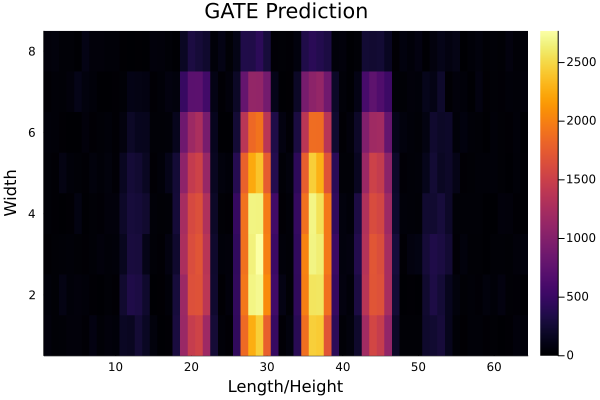

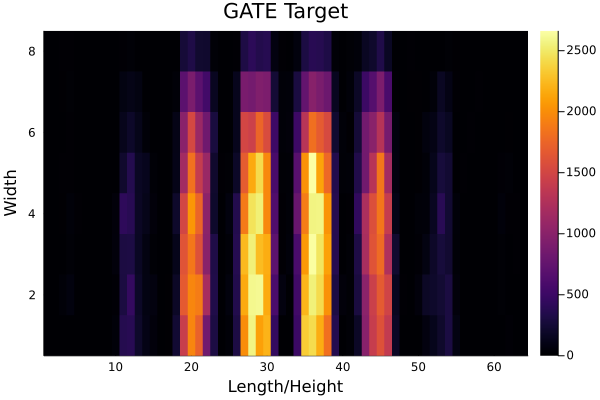

Validation R2: 0.9788487795512923

	1404

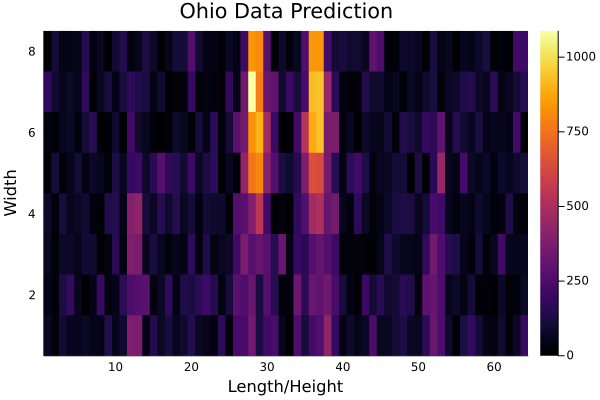

loss(trainingArray, targetArray) = 53979.48f0
loss(trainingArray, targetArray) = 53951.66f0
loss(trainingArray, targetArray) = 53904.41f0
loss(trainingArray, targetArray) = 53877.547f0
loss(trainingArray, targetArray) = 53849.062f0
loss(trainingArray, targetArray) = 53807.81f0
loss(trainingArray, targetArray) = 53780.883f0
loss(trainingArray, targetArray) = 53753.344f0
loss(trainingArray, targetArray) = 53714.977f0
Training R2: 0.9885838474981262


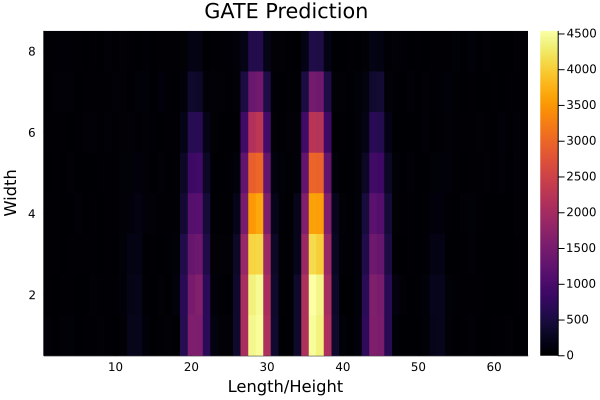

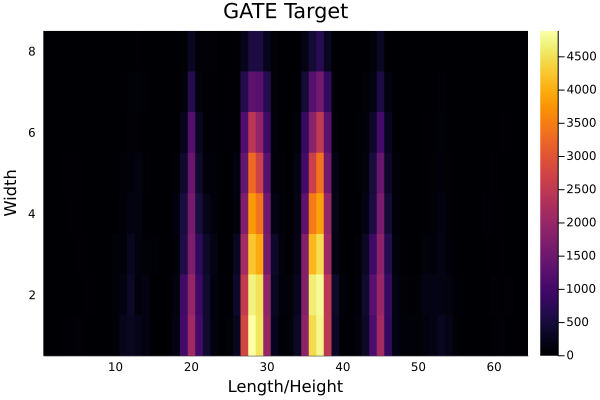

Validation R2: 0.9822200439556542

	2807

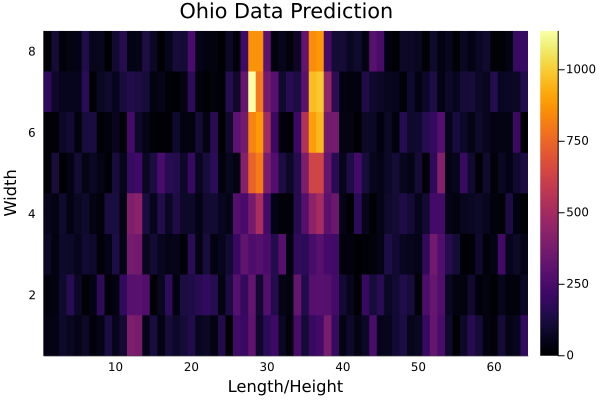

In [56]:
while i <= 10 && CVR2 < CurrentVR2
    CVR2 = CurrentVR2
    Flux.train!(loss, params(m), dataset, opt, cb = throttle(evalcb, 5))
    CurrentR2 = r2(lm(@formula(A  ~ B), DataFrame(A=Float64.(m(trainingArray)[:,1]), B=targetArray[:,1])))
    print("Training R2: ", CurrentR2, '\n')
    CurrentVR2 = r2(lm(@formula(A  ~ B), DataFrame(A=Float64.(m(validationArray)[:,1]), B=validationTargetArray[:,1])))
    print("Validation R2: ", CurrentVR2, '\n')
    print("\n\t")
    plotResults(m)
    i = i+1
end

In [57]:
function writeOutput(m)
    readPath = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    readArray = filter(x->occursin(string("A000"), x), readdir(readPath))
    readSize = size(readArray)[1]
    
    path = "/home/jupyter-nrmeskell/dosimeter/neural_nets/JuliaOutputs/OptimizedRuns"
    runNumber = lpad(size(readdir(path))[1], 3, "0")
    path = string(path, "/Run", runNumber, "R2-", lpad(Int(round(CurrentVR2, digits=3)*1000),3,"0"))
    mkdir(path)
    mkdir(string(path, "/fullSimulationOutputs"))
    mkdir(string(path, "/fullOhioOutputs"))
            
    for i = 1:size(validationTargetArray)[2]
        beamSize = filter(x->occursin(string("A000"), x), readdir(readPath))[div(i+2,3)][1:13]

        writedlm(string(path,"/fullSimulationOutputs/ValidationTarget",lpad(i,3,"0"), "-", beamSize, ".txt"), reshape(validationTargetArray[:,i], (8*8,8)), " ")
        writedlm(string(path,"/fullSimulationOutputs/ValidationOutput",lpad(i,3,"0"), "-", beamSize, ".txt"), reshape(m(validationArray)[:,i], (8*8,8)), " ")
    end


    readPath = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    readArray = filter(x->occursin(string("A000"), x), readdir(readPath))
    for i = 1:size(inputArray)[4]
        writedlm(string(path,"/fullOhioOutputs/OhioOutput",lpad(i,3,"0"),".txt"), Int.(round.(reshape(m(inputArray)[:,i], (8*8,8)))), " ")
    end
end

writeOutput (generic function with 1 method)

In [58]:
writeOutput(m)